# Задание 1.1 - Метод К-ближайших соседей (K-neariest neighbor classifier)

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Наша основная задача - научиться пользоваться numpy и представлять вычисления в векторном виде, а также ознакомиться с основными метриками, важными для задачи классификации.

Перед выполнением задания:
- запустите файл `download_data.sh`, чтобы скачать данные, которые мы будем использовать для тренировки
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt` (если раньше не работали с `pip`, вам сюда - https://pip.pypa.io/en/stable/quickstart/)

Если вы раньше не работали с numpy, вам может помочь tutorial. Например этот:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [20]:
mkdir data

A subdirectory or file data already exists.


In [1]:
import urllib.request
url = 'http://ufldl.stanford.edu/housenumbers/'
filename ='train_32x32.mat' 
urllib.request.urlretrieve(url, filename)

('train_32x32.mat', <http.client.HTTPMessage at 0x1bc9bf3fb80>)

In [2]:
import urllib.request
url = 'http://ufldl.stanford.edu/housenumbers/'
filename ='test_32x32.mat' 
urllib.request.urlretrieve(url, filename)

('test_32x32.mat', <http.client.HTTPMessage at 0x1bc9bf3d7b0>)

In [19]:
pwd

'C:\\Users\\nuke\\Desktop\\dlcourse_ai\\assignments\\assignment1'

In [2]:
import h5py

# Open the file as read only
h5f = h5py.File('data/SVHN_single_grey1.h5', 'r')

# Load the training and the test set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()
print("Shape of X_train: \n",X_train.shape)
print("Shape of y_train: \n",y_train.shape)
print("Shape of X_test: \n",X_test.shape)
print("Shape of y_test: \n",y_test.shape) 

Shape of X_train: 
 (42000, 32, 32)
Shape of y_train: 
 (42000,)
Shape of X_test: 
 (18000, 32, 32)
Shape of y_test: 
 (18000,)


In [10]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

# Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/), чтобы решать задачу хоть сколько-нибудь сложнее MNIST.

In [11]:
# train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)Данный подход лучше не юзать, вызывает проблемы в загрузке данных 

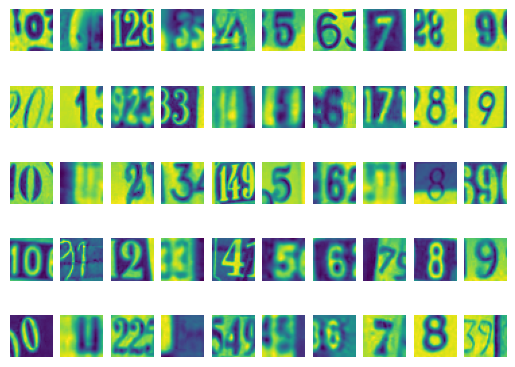

In [12]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = X_train[y_train == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

# Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [13]:
# First, let's prepare the labels and the source data
train_X, train_y, test_X, test_y = X_train, y_train, X_test, y_test 
# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to 1-dimensional array [num_samples, 32*32*3]
# binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
# binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)
binary_train_X.shape

(8382, 32, 32)

In [14]:
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], 32*32)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], 32*32)

In [15]:
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

In [16]:
print(binary_test_X)

[[ 79.8933  96.0057 102.9341 ...  86.8325 106.0155 122.8998]
 [135.502  134.5021 130.9755 ... 221.2166 221.2166 220.2167]
 [102.1979  99.91    97.2631 ...  54.6446  55.4057  55.8186]
 ...
 [164.1946 160.7219 159.836  ... 162.8787 163.7045 164.1883]
 [ 39.8662  29.8995  28.6438 ...  81.3197  87.8738  73.43  ]
 [137.5778 136.6919 134.8061 ... 144.7881 142.7883 141.7884]]


In [17]:
binary_test_X.shape
binary_test_X = binary_test_X[0:30]
binary_train_X = binary_train_X[0:70]

In [102]:
binary_test_y = binary_test_y[0:30]

In [107]:
binary_train_y = binary_train_y[0:70]

## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

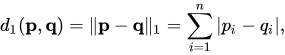

In [18]:
# TODO: implement compute_distances_two_loops in knn.py
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [19]:
dists[0, 10]

37062.82

In [20]:
# TODO: implement compute_distances_one_loop in knn.py
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
#assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))
#dists
np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))
# np.sum(np.abs(binary_test_X[0] - binary_train_X[10]))
# dists[0]
dists.shape

(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)


(30, 8382)

In [75]:
# TODO: implement compute_distances_no_loops in knn.py
dists = knn_classifier.compute_distances_no_loops(binary_test_X)

# dists = np.array(dists)

# dists.shape|
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))
# dists[0, 10]

(30, 8382, 1024)


In [74]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

1.45 s ± 38.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 1024)
(8382, 10

In [86]:
x = np.array([[1, 2, 3], [7, 3, 2], [9,8,7]])
for i in range(3):
    sort_y = []
    sort= np.argsort(x[i, :])
    print(sort)

[0 1 2]
[2 1 0]
[2 1 0]


In [91]:
# TODO: implement predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)

(30, 8382, 1024)


In [92]:
print(prediction)

[False  True False  True  True False  True False  True False False False
  True False False False  True False  True  True  True False  True False
  True  True False  True  True  True]


In [94]:
pip install scikit-learn

   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.3 MB 393.8 kB/s eta 0:00:24
   ---------------------------------------- 0.1/9.3 MB 544.7 kB/s eta 0:00:17
    --------------------------------------- 0.2/9.3 MB 833.5 kB/s eta 0:00:11
    --------------------------------------- 0.2/9.3 MB 748.1 kB/s eta 0:00:13
    --------------------------------------- 0.2/9.3 MB 778.2 kB/s eta 0:00:12
   - -------------------------------------- 0.3/9.3 MB 886.2 kB/s eta 0:00:11
   - -------------------------------------- 0.3/9.3 MB 905.4 kB/s eta 0:00:10
   - -------------------------------------- 0.4/9.3 MB 955.7 kB/s eta 0:00:10
   - -------------------------------------- 0.4/9.3 MB 904.2 kB/s eta 0:00:10
   - -------------------------------------- 0.4/9.3 MB 904.2 kB/s eta 0:00:10
   - --------

In [99]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def binary_classification_metrics(pred, y):
    return precision_score(y, pred), recall_score(y, pred), f1_score(y, pred), accuracy_score(y, pred)

In [103]:
# TODO: implement binary_classification_metrics in metrics.py
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.80, Precision: 0.69, Recall: 0.92, F1: 0.79


In [104]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

(30, 70, 1024)
KNN with k = 3
Accuracy: 0.53, Precision: 0.44, Recall: 0.67, F1: 0.53


# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение параметра k для алгоритма KNN! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [128]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y
splited_train = np.array_split(binary_test_X, num_folds)
splited_test_y = np.array_split(binary_test_y, num_folds)

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for k_c in k_choices:
    all_f1 = list()
    for i, test_fold_x in enumerate(splited_train):
        
        # TODO: perform cross-validation
        # Go through every fold and use it for testing and all other folds for training
        # Perform training and produce F1 score metric on the validation dataset
        # Average F1 from all the folds and write it into k_to_f1
        test_fold_y = splited_test_y[i]
        train_fold_x = np.concatenate(splited_train[:i] + splited_train[i + 1:])
        train_fold_y = np.concatenate(splited_test_y[:i] + splited_test_y[i + 1:])
        knn_classifier_3 = KNN(k=k_c)
        knn_classifier_3.fit(train_fold_x, train_fold_y)
        prediction = knn_classifier_3.predict(test_fold_x)
        f1 = f1_score(prediction, test_fold_y)
        all_f1.append(f1)
    f1 = np.mean(all_f1)
    k_to_f1[k_c] = f1

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

k = 1, f1 = 0.707619
k = 2, f1 = 0.500000
k = 3, f1 = 0.380000
k = 5, f1 = 0.313333
k = 8, f1 = 0.000000
k = 10, f1 = 0.133333
k = 15, f1 = 0.200000
k = 20, f1 = 0.000000
k = 25, f1 = 0.000000
k = 50, f1 = 0.000000


### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [108]:
# TODO Set the best k to the best value found by cross-validation
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

(30, 70, 1024)
Best KNN with k = 1
Accuracy: 0.67, Precision: 0.56, Recall: 0.83, F1: 0.67


# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [116]:
# Now let's use all 10 classes
train_X = train_X[0:140]
test_X = test_X[0:60]
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)
test_y = test_y[0:60]
knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [117]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)


(60, 140, 1024)


In [122]:
# TODO: Implement multiclass_accuracy

accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.13


Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [134]:
# Find the best k using cross-validation based on accuracy
num_folds = 5
train_folds_X = []
train_folds_y = []

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y
splited_train = np.array_split(binary_test_X, num_folds)
splited_test_y = np.array_split(binary_test_y, num_folds)


k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k_c in k_choices:
    all_f1 = list()
    for i, test_fold_x in enumerate(splited_train):
        
        # TODO: perform cross-validation
        # Go through every fold and use it for testing and all other folds for training
        # Perform training and produce F1 score metric on the validation dataset
        # Average F1 from all the folds and write it into k_to_f1
        test_fold_y = splited_test_y[i]
        train_fold_x = np.concatenate(splited_train[:i] + splited_train[i + 1:])
        train_fold_y = np.concatenate(splited_test_y[:i] + splited_test_y[i + 1:])
        knn_classifier_3 = KNN(k=k_c)
        knn_classifier_3.fit(train_fold_x, train_fold_y)
        prediction = knn_classifier_3.predict(test_fold_x)
        acc = multiclass_accuracy(prediction, test_fold_y)
        all_f1.append(acc)
    f1 = np.average(all_f1)
    k_to_accuracy[k_c] = f1

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

k = 1, accuracy = 0.766667
k = 2, accuracy = 0.700000
k = 3, accuracy = 0.600000
k = 5, accuracy = 0.633333
k = 8, accuracy = 0.533333
k = 10, accuracy = 0.600000
k = 15, accuracy = 0.566667
k = 20, accuracy = 0.600000
k = 25, accuracy = 0.600000
k = 50, accuracy = 0.600000


### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [163]:
import h5py

# Open the file as read only
h5f = h5py.File('data/SVHN_single_grey1.h5', 'r')

# Load the training and the test set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()
# print("Shape of X_train: \n",X_train.shape)
# print("Shape of y_train: \n",y_train.shape)
# print("Shape of X_test: \n",X_test.shape)
# print("Shape of y_test: \n",y_test.shape) 

train_X, train_y, test_X, test_y = X_train, y_train, X_test, y_test 

train_X = train_X[:10000]
train_y = train_y[:10000]

test_X = test_X[:250]
test_y = test_y[:250]

# TODO Set the best k as a best from computed
best_k = 1

train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.33
